### 1. 定义提示词格式函数

两种提示词风格：

1. Alpaca
    - 使用 "###" 作为分隔符
    - 使用 "### Instruction:" 作为指令
    - 使用 "### Response:" 作为响应
    - 使用 "### Input:" 作为输入
    - 使用 "### Output:" 作为输出

2. Phi-3
    - <|user|> 作为用户输入的开始
    - <|assistant|> 作为模型输出的开始
    - <|endoftext|> 作为结束


In [1]:
def format_input(entry):
    instruction_text = (
        f"Below is an instruction that describe a task. "
        f"Write a response that appropriately completes the request."
        f"\n\n### Instruction:\n{entry['instruction']}"
    )

    input_text = (
        f"\n\n### Input:\n{entry['input']}" if entry["input"] else ""
    )
    return instruction_text + input_text

In [2]:
from download_instruction_data import download_and_load_file, url, file_path

data = download_and_load_file(file_path, url)

print(format_input(data[50]), "\n")
print(format_input(data[999]))

Number of entries: 1100
Example entry: 
 {'instruction': 'Identify the correct spelling of the following word.', 'input': 'Ocassion', 'output': "The correct spelling is 'Occasion.'"}
Below is an instruction that describe a task. Write a response that appropriately completes the request.

### Instruction:
Identify the correct spelling of the following word.

### Input:
Ocassion 

Below is an instruction that describe a task. Write a response that appropriately completes the request.

### Instruction:
What is an antonym of 'complicated'?


### 2. 划分数据集

In [3]:
train_portion = int(len(data) * 0.85)
test_portion = int(len(data) * 0.1)
val_portion = len(data) - train_portion - test_portion

train_data = data[:train_portion]
test_data = data[train_portion: train_portion + test_portion]
val_data = data[train_portion+test_portion:]

print("Training set length:", len(train_data))
print("Validation set length:", len(val_data))
print("Test set length:", len(test_data))

Training set length: 935
Validation set length: 55
Test set length: 110


### 3. 将数据组织成训练批次

1. 使用提示词模版制作格式化数据
2. 将格式化数据词元化
3. 用填充词元调整到同一长度（批内相同）
4. 创建目标词元 ID 用于训练（左移一位）
5. 用占位符 -100 替换填充词元（忽略这部分的损失计算）

#### 3.1/3.2 使用提示词模版制作格式化数据 & 将格式化数据词元化

In [4]:
import torch
from torch.utils.data import Dataset

class InstructionDataset(Dataset):
    def __init__(self, data, tokenizer):
        self.data = data
        self.encoded_texts = []
        for entry in data:
            instruction_plus_input = format_input(entry)
            response_text = f"\n\n### Response:\n{entry['output']}"
            full_text = instruction_plus_input + response_text
            self.encoded_texts.append(
                tokenizer.encode(full_text)
            )

    def __getitem__(self, index) :
        return self.encoded_texts[index]

    def __len__(self):
        return len(self.data)

#### 3.3 用填充词元调整到同一长度（批内相同）

In [5]:
def custom_collate_draft_1(
    batch,
    pad_token_id=50256,
    device="cpu",
):
    batch_max_length = max(len(item) + 1 for item in batch)
    inputs_lst = []

    for item in batch:
        new_item = item.copy()
        new_item += [pad_token_id]

        padded = (
            new_item + [pad_token_id] * 
            (batch_max_length - len(new_item))
        )
        inputs = torch.tensor(padded[:-1])
        inputs_lst.append(inputs)
    
    inputs_tensor = torch.stack(inputs_lst).to(device)
    return inputs_tensor

In [6]:
inputs_1 = [0, 1, 2, 3, 4]
inputs_2 = [5, 6]
inputs_3 = [7, 8, 9]
batch = (
    inputs_1,
    inputs_2,
    inputs_3,
)
print(custom_collate_draft_1(batch))

tensor([[    0,     1,     2,     3,     4],
        [    5,     6, 50256, 50256, 50256],
        [    7,     8,     9, 50256, 50256]])


#### 3.4 创建目标词元 ID 用于训练

In [7]:
def custom_collate_draft_2(
    batch,
    pad_token_id=50256,
    device="cpu"
):
    batch_max_length = max(len(item)+1 for item in batch)
    inputs_lst, targets_lst = [], []

    for item in batch:
        new_item = item.copy()
        new_item += [pad_token_id]
        padded = (
            new_item + [pad_token_id] *
            (batch_max_length - len(new_item))
        )
        inputs = torch.tensor(padded[:-1])
        targets = torch.tensor(padded[1:]) # 左移一个位置得到目标
        inputs_lst.append(inputs)
        targets_lst.append(targets)

    inputs_tensor = torch.stack(inputs_lst).to(device)
    targets_tensor = torch.stack(targets_lst).to(device)
    return inputs_tensor, targets_tensor

In [8]:
inputs, targets = custom_collate_draft_2(batch)
print(inputs)
print(targets)

tensor([[    0,     1,     2,     3,     4],
        [    5,     6, 50256, 50256, 50256],
        [    7,     8,     9, 50256, 50256]])
tensor([[    1,     2,     3,     4, 50256],
        [    6, 50256, 50256, 50256, 50256],
        [    8,     9, 50256, 50256, 50256]])


#### 3.5 用占位符 -100 替换部分填充词元

In [9]:
def custom_collate_fn(
    batch,
    pad_token_id=50256,
    ignore_index=-100,
    allowed_max_length=None,
    device="cpu"
):
    batch_max_length = max(len(item) + 1 for item in batch)
    inputs_lst, targets_lst = [], []

    for item in batch:
        new_item = item.copy()
        new_item += [pad_token_id]

        padded = (
            new_item + [pad_token_id] *
            (batch_max_length - len(new_item))
        )
        inputs = torch.tensor(padded[:-1])
        targets = torch.tensor(padded[1:])
        mask = targets == pad_token_id
        indices = torch.nonzero(mask).squeeze()
        if indices.numel() > 1:
            targets[indices[1:]] = ignore_index
        
        if allowed_max_length is not None:
            inputs = inputs[:allowed_max_length]
            targets = targets[:allowed_max_length]
        
        inputs_lst.append(inputs)
        targets_lst.append(targets)
    
    inputs_tensor = torch.stack(inputs_lst).to(device)
    targets_tensor = torch.stack(targets_lst).to(device)
    return inputs_tensor, targets_tensor

In [10]:
inputs, targets = custom_collate_fn(batch)
print(inputs)
print(targets)

tensor([[    0,     1,     2,     3,     4],
        [    5,     6, 50256, 50256, 50256],
        [    7,     8,     9, 50256, 50256]])
tensor([[    1,     2,     3,     4, 50256],
        [    6, 50256,  -100,  -100,  -100],
        [    8,     9, 50256,  -100,  -100]])


### 4. 创建指令数据集的数据加载器

In [11]:
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
print(device)

mps


In [12]:
from functools import partial

customized_collate_fn = partial(
    custom_collate_fn,
    device=device,
    allowed_max_length=1024,
)

In [13]:
import tiktoken
tokenizer = tiktoken.get_encoding("gpt2")

In [14]:
from torch.utils.data import DataLoader

num_workers = 0
batch_size = 8

torch.manual_seed(123)

train_dataset = InstructionDataset(train_data, tokenizer)
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    collate_fn=customized_collate_fn,
    shuffle=True,
    drop_last=True,
    num_workers=num_workers,
)

val_dataset = InstructionDataset(val_data, tokenizer)
val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    collate_fn=customized_collate_fn,
    shuffle=False,
    drop_last=False,
    num_workers=num_workers,
)

test_dataset = InstructionDataset(test_data, tokenizer)
test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    collate_fn=customized_collate_fn,
    shuffle=False,
    drop_last=False,
    num_workers=num_workers,
)

In [15]:
print(InstructionDataset)
print(type(InstructionDataset))

print("Train loader:")
for inputs, targets in train_loader:
    print(inputs.shape, targets.shape)

<class '__main__.InstructionDataset'>
<class 'type'>
Train loader:
torch.Size([8, 61]) torch.Size([8, 61])
torch.Size([8, 76]) torch.Size([8, 76])
torch.Size([8, 73]) torch.Size([8, 73])
torch.Size([8, 68]) torch.Size([8, 68])
torch.Size([8, 65]) torch.Size([8, 65])
torch.Size([8, 72]) torch.Size([8, 72])
torch.Size([8, 80]) torch.Size([8, 80])
torch.Size([8, 67]) torch.Size([8, 67])
torch.Size([8, 62]) torch.Size([8, 62])
torch.Size([8, 75]) torch.Size([8, 75])
torch.Size([8, 62]) torch.Size([8, 62])
torch.Size([8, 68]) torch.Size([8, 68])
torch.Size([8, 67]) torch.Size([8, 67])
torch.Size([8, 77]) torch.Size([8, 77])
torch.Size([8, 69]) torch.Size([8, 69])
torch.Size([8, 79]) torch.Size([8, 79])
torch.Size([8, 71]) torch.Size([8, 71])
torch.Size([8, 66]) torch.Size([8, 66])
torch.Size([8, 83]) torch.Size([8, 83])
torch.Size([8, 68]) torch.Size([8, 68])
torch.Size([8, 80]) torch.Size([8, 80])
torch.Size([8, 71]) torch.Size([8, 71])
torch.Size([8, 69]) torch.Size([8, 69])
torch.Size([8

### 5. 加载预训练的大语言模型

使用 3.55 亿的中等规模 GPT 模型。

In [16]:
from gpt_download import download_and_load_gpt2
from gpt_model import GPTModel
from load_gpt2 import load_weights_into_gpt

BASE_CONFIG = {
    "vocab_size": 50257,
    "context_length": 1024,
    "drop_rate": 0.0,
    "qkv_bias": True,
}

model_configs = {
    "gpt2-small (124M)": {"emb_dim": 768, "n_layers": 12, "n_heads": 12},
    "gpt2-medium (355M)": {"emb_dim": 1024, "n_layers": 24, "n_heads": 16},
    "gpt2-large (774M)": {"emb_dim": 1280, "n_layers": 36, "n_heads": 20},
    "gpt2-xl (1558M)": {"emb_dim": 1600, "n_layers": 48, "n_heads": 25},
}

CHOOSE_MODEL = "gpt2-medium (355M)"

BASE_CONFIG.update(model_configs[CHOOSE_MODEL])

model_size = CHOOSE_MODEL.split(" ")[-1].lstrip("(").rstrip(")")

settings, params = download_and_load_gpt2(
    model_size=model_size,
    models_dir="gpt2"
)

model = GPTModel(BASE_CONFIG)
load_weights_into_gpt(model, params)
model.eval()

torch.Size([2, 6, 3])
File already exists and is up-to-date: gpt2/355M/checkpoint
File already exists and is up-to-date: gpt2/355M/encoder.json
File already exists and is up-to-date: gpt2/355M/hparams.json
File already exists and is up-to-date: gpt2/355M/model.ckpt.data-00000-of-00001
File already exists and is up-to-date: gpt2/355M/model.ckpt.index
File already exists and is up-to-date: gpt2/355M/model.ckpt.meta
File already exists and is up-to-date: gpt2/355M/vocab.bpe


GPTModel(
  (tok_emb): Embedding(50257, 1024)
  (pos_emb): Embedding(1024, 1024)
  (drop_emb): Dropout(p=0.0, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=1024, out_features=1024, bias=True)
        (W_key): Linear(in_features=1024, out_features=1024, bias=True)
        (W_value): Linear(in_features=1024, out_features=1024, bias=True)
        (out_proj): Linear(in_features=1024, out_features=1024, bias=True)
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=1024, out_features=4096, bias=True)
          (1): GELU()
          (2): Linear(in_features=4096, out_features=1024, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.0, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(i

In [17]:
torch.manual_seed(123)
input_text = format_input(val_data[0])
print("Input text:\n", input_text)


from gpt_model import generate, token_ids_to_text, text_to_token_ids

token_ids = generate(
    model=model,
    idx=text_to_token_ids(input_text, tokenizer),
    max_new_tokens=35,
    context_length=BASE_CONFIG["context_length"],
    eos_id=50256,
)

generated_text = token_ids_to_text(token_ids, tokenizer)
response_text = generated_text[len(input_text):].strip()
print("\n\n===========\nResponse:\n", response_text)

Input text:
 Below is an instruction that describe a task. Write a response that appropriately completes the request.

### Instruction:
Convert the active sentence to passive: 'The chef cooks the meal every day.'


Response:
 ### Response:

The chef cooks the meal every day.

### Instruction:

Convert the active sentence to passive: 'The chef cooks the


### 6. 在指令数据上微调大语言模型

In [18]:
from train import  calc_loss_loader, train_model_simple

model.to(device)
torch.manual_seed(123)

with torch.no_grad():
    train_loss = calc_loss_loader(train_loader, model, device, num_batches=5)
    val_loss = calc_loss_loader(val_loader, model, device, num_batches=5)
print("Training loss:", train_loss)
print("Validation loss:", val_loss)

Training loss: 3.904631185531616
Validation loss: 3.842133808135986


In [20]:
import time

start_time = time.time()
torch.manual_seed(123)
optimizer = torch.optim.AdamW(
    model.parameters(), lr=1e-5, weight_decay=0.1,
)
num_epochs = 2

train_losses, val_losses, tokens_seen = train_model_simple(
    model, train_loader, val_loader, optimizer, device,
    num_epochs=num_epochs, eval_freq=5, eval_iter=5,
    start_context=format_input(val_data[0]), tokenizer=tokenizer,
)

end_time = time.time()
execution_time_minutes = (end_time - start_time) / 60
print(f"Training completed in {execution_time_minutes:.2f} minutes.")

Ep 1 (Step 000000):Train loss 4.034, Val loss 4.448
Ep 1 (Step 000005):Train loss 3.096, Val loss 3.181
Ep 1 (Step 000010):Train loss 2.074, Val loss 2.353
Ep 1 (Step 000015):Train loss 1.592, Val loss 1.781
Ep 1 (Step 000020):Train loss 1.246, Val loss 1.466
Ep 1 (Step 000025):Train loss 1.106, Val loss 1.277
Ep 1 (Step 000030):Train loss 1.181, Val loss 1.228
Ep 1 (Step 000035):Train loss 1.016, Val loss 1.163
Ep 1 (Step 000040):Train loss 0.973, Val loss 1.116
Ep 1 (Step 000045):Train loss 0.940, Val loss 1.078
Ep 1 (Step 000050):Train loss 1.022, Val loss 1.045
Ep 1 (Step 000055):Train loss 1.050, Val loss 1.020
Ep 1 (Step 000060):Train loss 0.982, Val loss 0.994
Ep 1 (Step 000065):Train loss 0.895, Val loss 0.976
Ep 1 (Step 000070):Train loss 0.819, Val loss 0.959
Ep 1 (Step 000075):Train loss 0.806, Val loss 0.946
Ep 1 (Step 000080):Train loss 0.881, Val loss 0.938
Ep 1 (Step 000085):Train loss 0.776, Val loss 0.931
Ep 1 (Step 000090):Train loss 0.880, Val loss 0.921
Ep 1 (Step 0

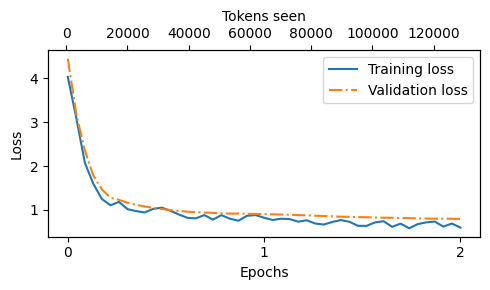

In [21]:
from train import plot_losses

epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
plot_losses(epochs_tensor, tokens_seen, train_losses, val_losses)

### 7. 提取并保存模型回复

#### 7.1 打印测试集前 3 个看看效果

In [22]:
torch.manual_seed(123)

for entry in test_data[:3]:
    input_text = format_input(entry)
    token_ids = generate(
        model=model,
        idx=text_to_token_ids(input_text, tokenizer).to(device),
        max_new_tokens=256,
        context_length=BASE_CONFIG["context_length"],
        eos_id=50256,
    )
    generated_text = token_ids_to_text(token_ids, tokenizer)

    response_text = (
        generated_text[len(input_text):]
        .replace("### Response:", "")
        .strip()
    )
    
    print(input_text)
    print(f"\nCorrect response:\n>> {entry['output']}")
    print(f"\nModel response:\n>> {response_text.strip()}")
    print("-------------------------------------")


Below is an instruction that describe a task. Write a response that appropriately completes the request.

### Instruction:
Rewrite the sentence using a simile.

### Input:
The car is very fast.

Correct response:
>> The car is as fast as lightning.

Model response:
>> The car is very fast.
-------------------------------------
Below is an instruction that describe a task. Write a response that appropriately completes the request.

### Instruction:
What type of cloud is typically associated with thunderstorms?

Correct response:
>> The type of cloud typically associated with thunderstorms is cumulonimbus.

Model response:
>> The type of cloud associated with thunderstorms is typically a thunderstorm with a high wind speed.
-------------------------------------
Below is an instruction that describe a task. Write a response that appropriately completes the request.

### Instruction:
Name the author of 'Pride and Prejudice'.

Correct response:
>> Jane Austen.

Model response:
>> The author

#### 7.2 生成完整测试集上的回复

In [23]:
import json
from tqdm import tqdm

for i, entry in tqdm(enumerate(test_data), total=len(test_data)):
    input_text = format_input(entry)

    token_ids = generate(
        model=model,
        idx=text_to_token_ids(input_text, tokenizer).to(device),
        max_new_tokens=256,
        context_length=BASE_CONFIG["context_length"],
        eos_id=50256,
    )
    generated_text = token_ids_to_text(token_ids, tokenizer)

    response_text = (
        generated_text[len(input_text):]
        .replace("### Response:", "")
        .strip()
    )

    test_data[i]["model_response"] = response_text

with open("instruction-data-with-response.json", "w") as file:
    json.dump(test_data, file, indent=4)

100%|██████████| 110/110 [03:36<00:00,  1.97s/it]


In [35]:
from rich import print as rprint

rprint(test_data[0])

{
    'instruction': 'Rewrite the sentence using a simile.',
    'input': 'The car is very fast.',
    'output': 'The car is as fast as lightning.',
    'model_response': 'The car is very fast.'
}

#### 7.3 保存模型

In [25]:
import re

file_name = f"{re.sub(r'[ ()]', '', CHOOSE_MODEL) }-sft.pth"
torch.save(model.state_dict(), file_name)
print(f"Model saved as {file_name}")

Model saved as gpt2-medium355M-sft.pth


### 8. 使用 llama 评估微调后的大语言模型

In [29]:
from llama import query_model

for entry in test_data[:3]:
    prompt = (
        f"Given the input `{format_input(entry)}` "
        f"and correct output `{entry['output']}`, "
        f"score the model response `{entry['model_response']}`"
        f" on a scale from 0 to 100, where 100 is the best score. "
    )
    print("\nDataset response:")
    print(">>", entry['output'])
    print("\nModel response:")
    print(">>", entry["model_response"])
    print("\nScore:")
    print(">>", query_model(prompt))
    print("\n-------------------------")


Dataset response:
>> The car is as fast as lightning.

Model response:
>> The car is very fast.

Score:
>> To rewrite the sentence using a simile, we can replace "very" with "as" and add "like" or "as" to make it a comparison.

Corrected response: The car is as fast as lightning.

Score: 100 (The model response was correct and provided a perfect example of how to rewrite the sentence using a simile.)

-------------------------

Dataset response:
>> The type of cloud typically associated with thunderstorms is cumulonimbus.

Model response:
>> The type of cloud associated with thunderstorms is typically a thunderstorm with a high wind speed.

Score:
>> Score: 20

Reasoning:

* The model's response does not directly answer the question about the type of cloud associated with thunderstorms.
* It mentions "thunderstorm" which is related to the topic but it's not a specific type of cloud.
* It also includes irrelevant information like "high wind speed", which is not relevant to the question

In [33]:
def generate_model_scores(json_data, json_key, model="llama3.2"):
    scores = []
    for entry in tqdm(json_data, desc="Scoring entries"):
        prompt = (
            f"Given the input `{format_input(entry)}` "
            f"and correct output `{entry['output']}`, "
            f"score the model response `{entry[json_key]}`"
            f" on a scale from 0 to 100, where 100 is the best score. "
            f"Respond with the integer number only."
        )
        score = query_model(prompt, model)
        try:
            scores.append(int(score))
        except ValueError:
            # print(f"Could not convert score: {score}")
            continue
    return scores

In [34]:
scores = generate_model_scores(test_data, "model_response")
print(f"Number of scores: {len(scores)} of {len(test_data)}")
print(f"Average score: {sum(scores)/len(scores):.2f}\n")

Scoring entries: 100%|██████████| 110/110 [00:25<00:00,  4.28it/s]

Number of scores: 91 of 110
Average score: 48.62

